 **IMPORTING USEFUL PACKAGES**

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

**Showing Results**

In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

 **Generator Model**

In [3]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''

        #     Steps:
        #       1) Do a transposed convolution using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a ReLU activation.
        #       4) If its the final layer, use a Tanh activation after the deconvolution.

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels,output_channels,kernel_size,stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU()
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels,output_channels,kernel_size,stride),
                nn.Tanh()
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cuda'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

**Discriminator**

In [4]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        #     Steps:
        #       1) Add a convolutional layer using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a LeakyReLU activation with slope 0.2.
        #       Note: Don't use an activation on the final layer
        
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels,output_channels,kernel_size,stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(negative_slope=0.2)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.Conv2d(input_channels,output_channels,kernel_size,stride)
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

**Training**

In [5]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum, which you can read more about here:
# https://distill.pub/2017/momentum/ but you don’t need to worry about it for this course!
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, step 500: Generator loss: 0.9398129102587698, discriminator loss: 0.5308345490396025


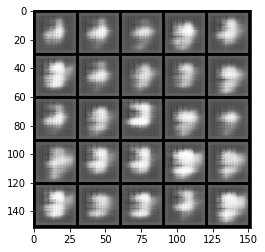

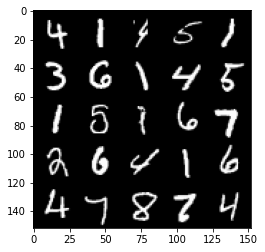

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, step 1000: Generator loss: 1.263410354971886, discriminator loss: 0.4924380728006361


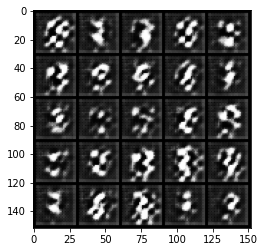

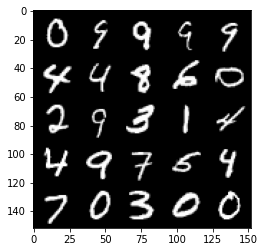

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, step 1500: Generator loss: 0.9794215306937695, discriminator loss: 0.5873824717998504


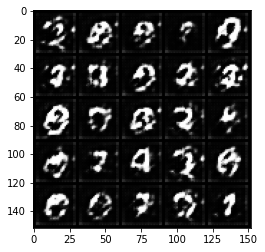

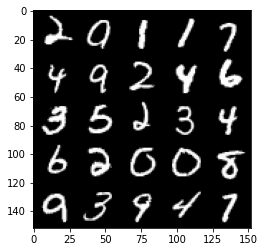

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, step 2000: Generator loss: 0.8653779862523082, discriminator loss: 0.623098078966141


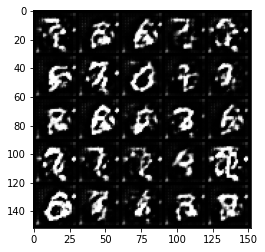

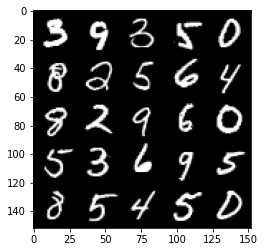

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, step 2500: Generator loss: 0.800565459132194, discriminator loss: 0.6471115010976797


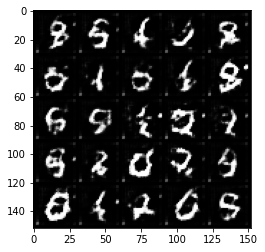

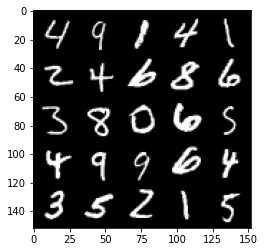

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6, step 3000: Generator loss: 0.7777231429815293, discriminator loss: 0.662204561710358


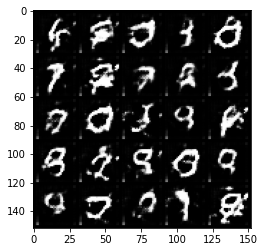

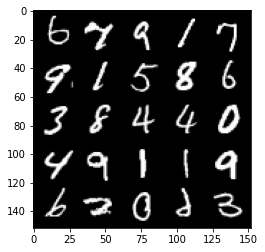

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7, step 3500: Generator loss: 0.7700772364139549, discriminator loss: 0.6655535864830022


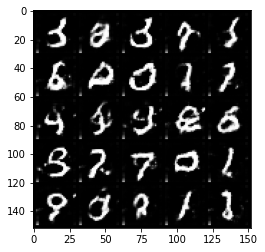

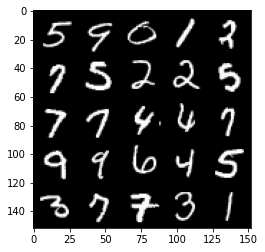

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8, step 4000: Generator loss: 0.7532441119551657, discriminator loss: 0.6754009051322931


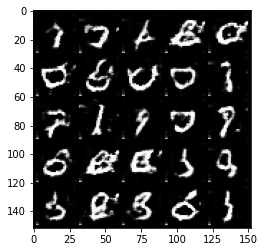

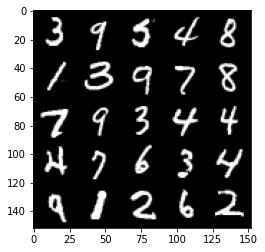

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9, step 4500: Generator loss: 0.7517881980538366, discriminator loss: 0.6751102756261822


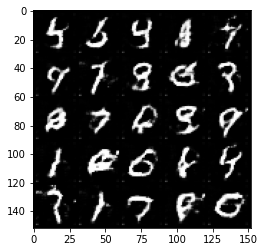

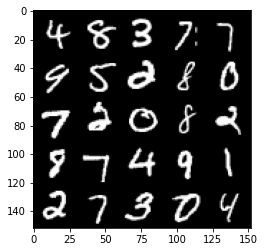

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10, step 5000: Generator loss: 0.7404888350963598, discriminator loss: 0.6765007040500646


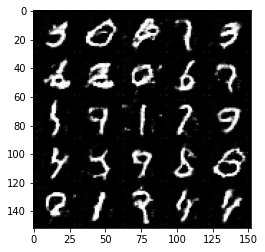

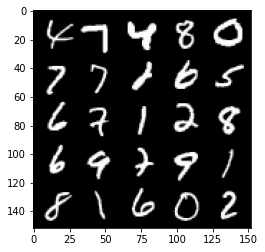

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11, step 5500: Generator loss: 0.7333028100132944, discriminator loss: 0.681811390161514


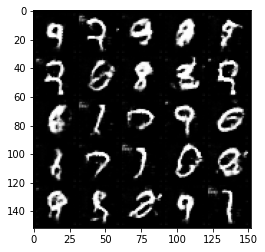

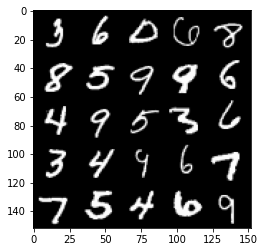

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12, step 6000: Generator loss: 0.7311283586621288, discriminator loss: 0.6860831984281542


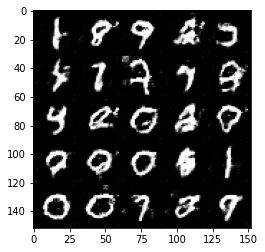

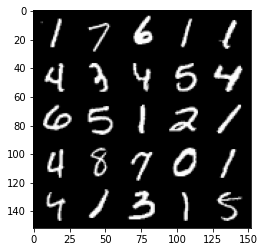

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13, step 6500: Generator loss: 0.7279816734194747, discriminator loss: 0.6865306158065788


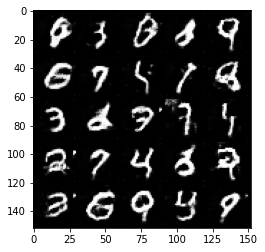

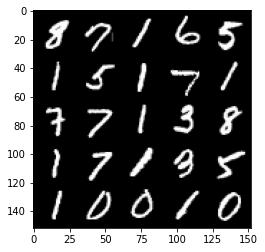

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14, step 7000: Generator loss: 0.7231538028120998, discriminator loss: 0.6886231824159624


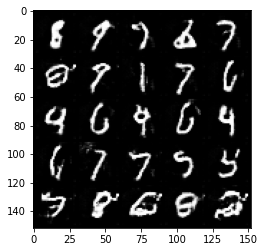

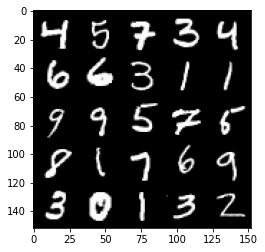

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15, step 7500: Generator loss: 0.7208599062561992, discriminator loss: 0.6890324894189833


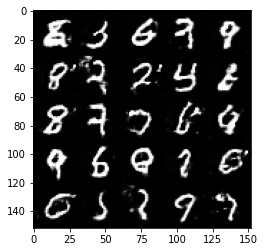

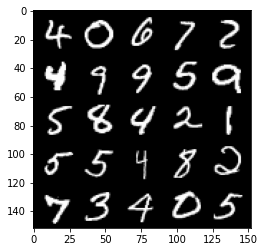

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17, step 8000: Generator loss: 0.7183013067841532, discriminator loss: 0.6914050160646442


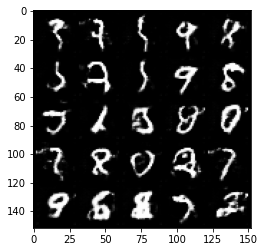

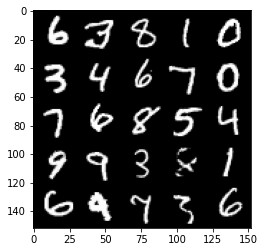

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18, step 8500: Generator loss: 0.7181513598561283, discriminator loss: 0.690833763599396


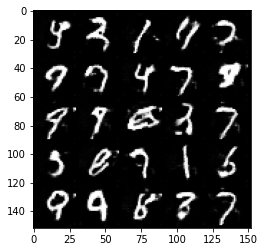

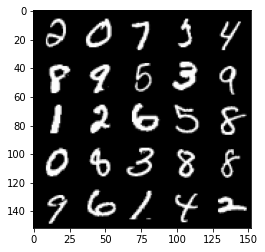

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19, step 9000: Generator loss: 0.7157443697452551, discriminator loss: 0.6924421070814126


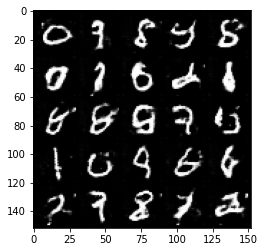

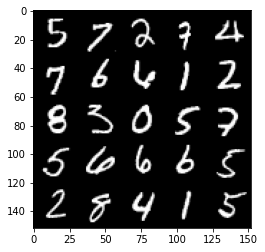

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20, step 9500: Generator loss: 0.7128790742158888, discriminator loss: 0.6924960774183274


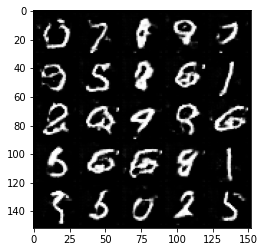

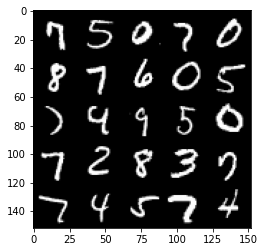

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 21, step 10000: Generator loss: 0.713682064712047, discriminator loss: 0.6935857197046272


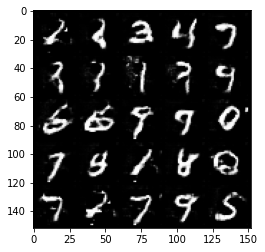

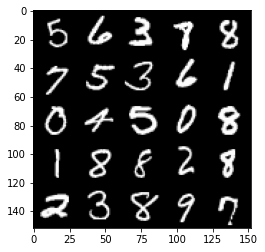

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 22, step 10500: Generator loss: 0.7115720770955082, discriminator loss: 0.6948812747001641


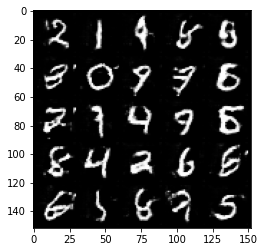

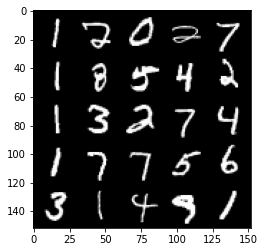

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 23, step 11000: Generator loss: 0.7089979390501978, discriminator loss: 0.6936139533519748


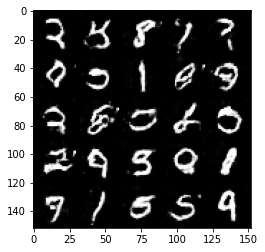

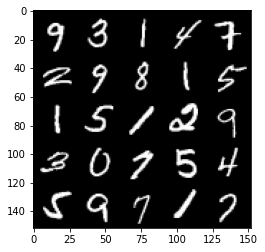

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 24, step 11500: Generator loss: 0.7070631445646289, discriminator loss: 0.6936278882026675


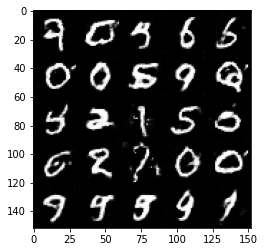

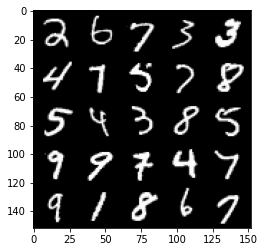

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 25, step 12000: Generator loss: 0.7073934352993964, discriminator loss: 0.693895604372025


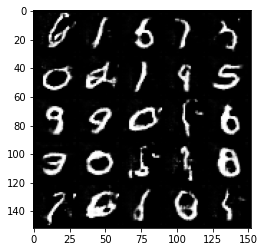

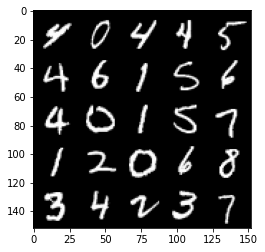

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 26, step 12500: Generator loss: 0.7074420007467264, discriminator loss: 0.6941722991466522


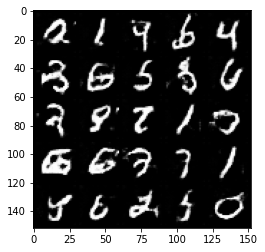

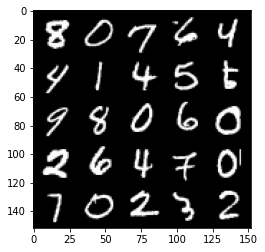

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 27, step 13000: Generator loss: 0.7047957402467729, discriminator loss: 0.6936418914794922


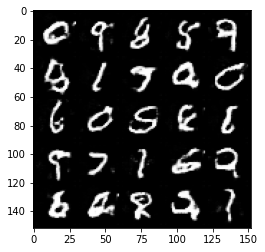

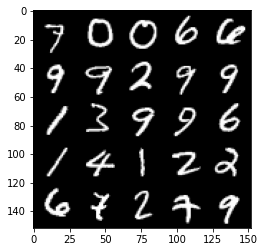

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 28, step 13500: Generator loss: 0.7045548677444449, discriminator loss: 0.6946958254575727


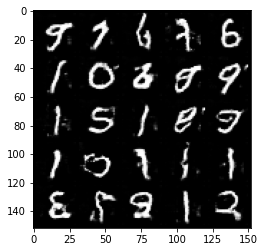

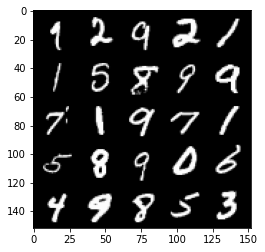

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 29, step 14000: Generator loss: 0.7037917728424066, discriminator loss: 0.6945794508457187


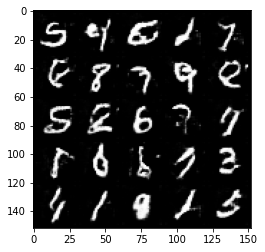

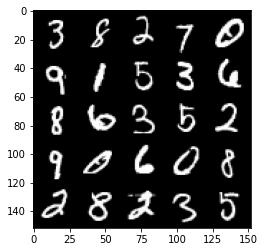

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 30, step 14500: Generator loss: 0.7046912747621538, discriminator loss: 0.6942930341958996


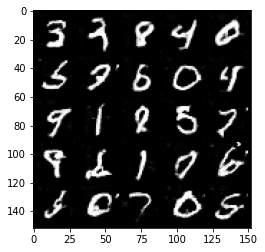

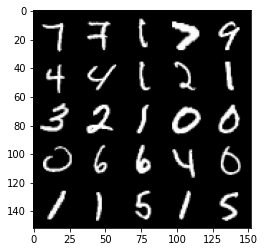

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 31, step 15000: Generator loss: 0.703388042926788, discriminator loss: 0.6948543823957442


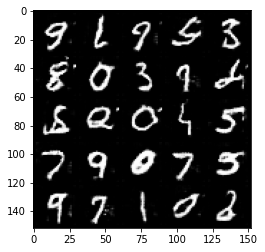

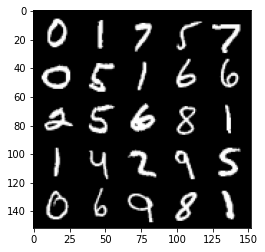

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 33, step 15500: Generator loss: 0.7013001344203947, discriminator loss: 0.6947836014032364


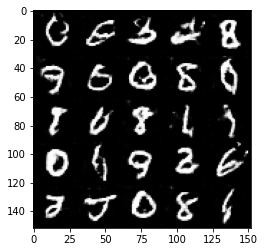

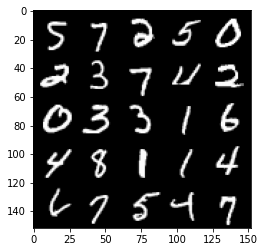

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 34, step 16000: Generator loss: 0.7015767720937728, discriminator loss: 0.6946916958093645


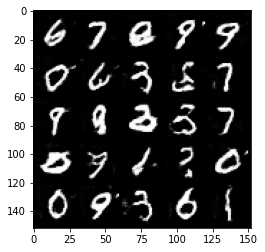

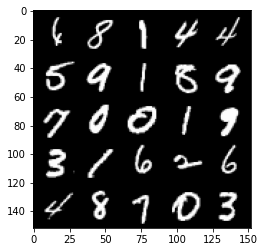

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 35, step 16500: Generator loss: 0.7013604897260652, discriminator loss: 0.6949838185310359


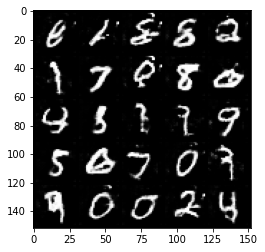

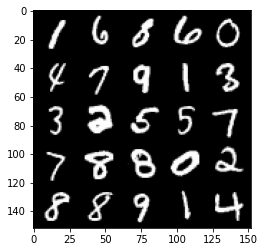

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 36, step 17000: Generator loss: 0.6989959022998805, discriminator loss: 0.6948771349191664


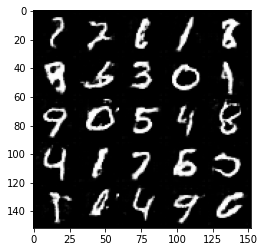

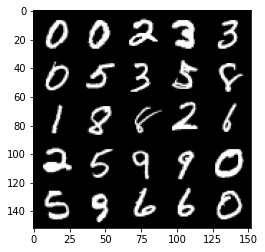

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 37, step 17500: Generator loss: 0.6995848571062088, discriminator loss: 0.6948233096599582


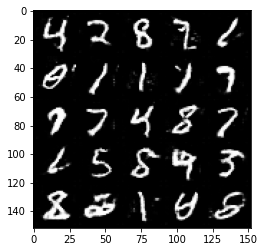

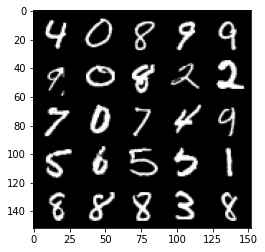

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 38, step 18000: Generator loss: 0.6985752075910568, discriminator loss: 0.6947067052125931


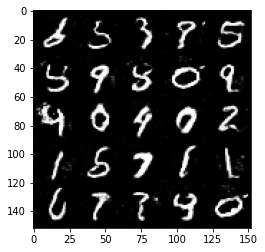

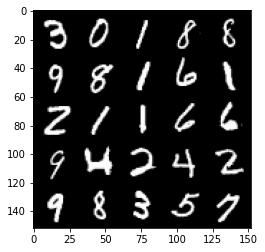

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 39, step 18500: Generator loss: 0.6994399436712272, discriminator loss: 0.6949308111667627


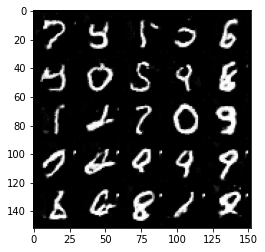

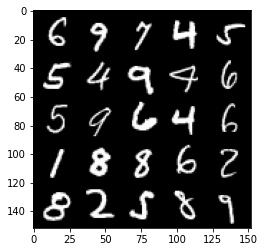

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 40, step 19000: Generator loss: 0.6985129723548891, discriminator loss: 0.6947256199121477


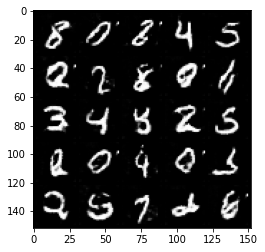

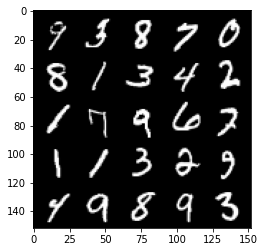

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 41, step 19500: Generator loss: 0.6992644062042234, discriminator loss: 0.6946635531187058


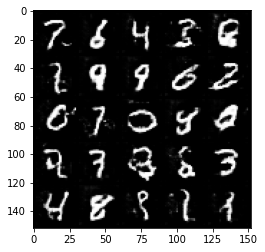

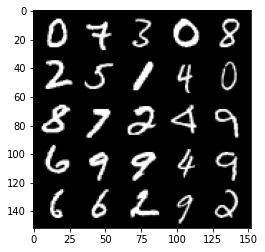

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 42, step 20000: Generator loss: 0.6972580693960195, discriminator loss: 0.6945915983915327


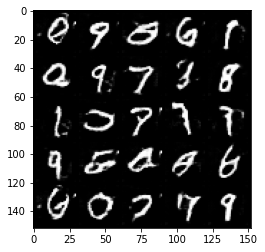

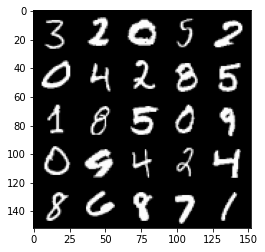

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 43, step 20500: Generator loss: 0.6968438431024555, discriminator loss: 0.6942698380947114


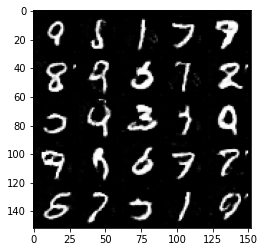

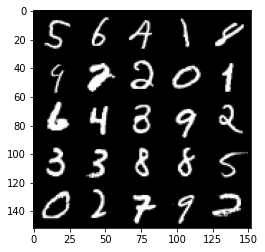

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 44, step 21000: Generator loss: 0.6974798369407661, discriminator loss: 0.6946191304922101


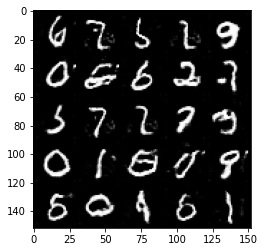

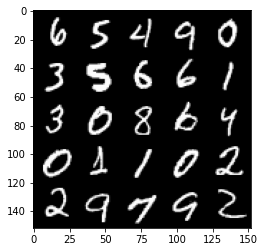

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 45, step 21500: Generator loss: 0.6962704493999473, discriminator loss: 0.6943507369756705


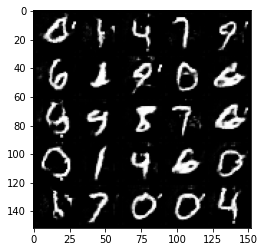

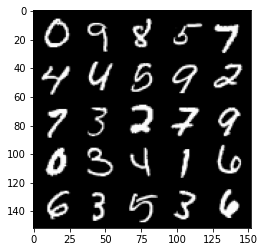

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 46, step 22000: Generator loss: 0.6961784470081334, discriminator loss: 0.6942823796272282


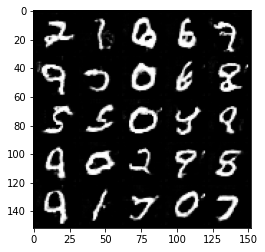

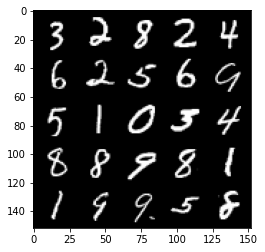

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 47, step 22500: Generator loss: 0.6962366120815282, discriminator loss: 0.6941910833120344


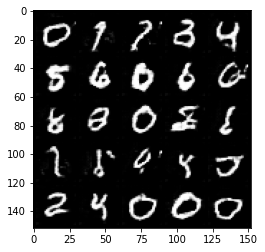

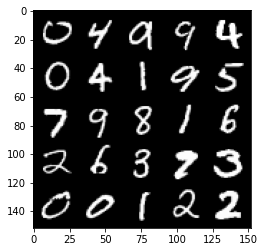

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 49, step 23000: Generator loss: 0.6961610562801351, discriminator loss: 0.6940760661363603


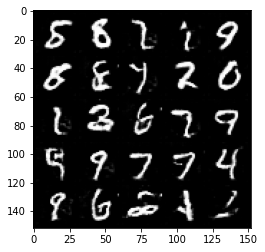

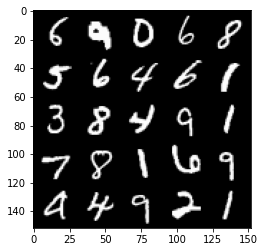

In [7]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
gen_losses = []
disc_losses = []
counter=0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        disc_losses.append(disc_loss.item())
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        gen_losses.append(gen_loss.item())
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
        counter += 1

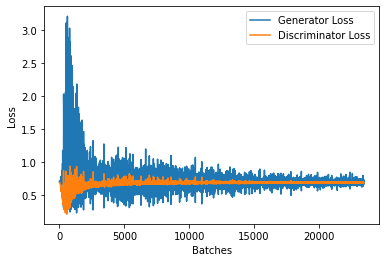

In [8]:
fig, axis = plt.subplots()
axis.plot(np.arange(counter),gen_losses,label="Generator Loss")
axis.plot(np.arange(counter),disc_losses,label="Discriminator Loss")
plt.ylabel('Loss')
plt.xlabel('Batches')
axis.legend()
plt.show()